# 資料處理

In [3]:
TrainDataFile = 'digits_train.csv'
TestDataFile  = 'digits_test.csv'
TargetColumn  = 'CLAIM_FLG'
DropColumns   = 'INSD_ID_SAS' #CUST_ID','OCCUPATION_f','OCCUPATION','CITY_CODE','AGE'
OutputAnswer  = 'finaldata'
OtherPredict = ''#'LightGBM', 'RidgeClassifier','SVM','K-NN'
n_splits = 3

In [4]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns
import plotly.offline    as py
import os, csv, timeit
from sklearn.base          import TransformerMixin
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, Normalizer,QuantileTransformer
from sklearn.pipeline      import make_pipeline
from sklearn.decomposition import PCA, TruncatedSVD, NMF,MiniBatchSparsePCA,DictionaryLearning,FastICA,FactorAnalysis
from sklearn.manifold      import TSNE
from sklearn.utils         import shuffle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics               import accuracy_score,f1_score,roc_auc_score,precision_score,recall_score,confusion_matrix,classification_report,cohen_kappa_score,hamming_loss,jaccard_similarity_score
#from imblearn.under_sampling       import RandomUnderSampler
from plotly.graph_objs             import *
if not os.path.exists(r'Model'):
    os.makedirs(r'Model') 

pd.set_option('display.max_columns', 500)
%autosave 180 
%matplotlib inline
py.init_notebook_mode(connected=True)

Autosaving every 180 seconds


In [5]:
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['MLENS_BACKEND'] = 'multiprocessing'
plt.style.use('seaborn')
plt.rcParams['figure.dpi'] = 144
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['axes.unicode_minus'] = False
sns.set(font_scale = 0.7,font = "Microsoft JhengHei")

import xlrd
import unicodecsv

def xls2csv (filename):
    if filename.split('.')[-1] in ( 'csv' , 'txt'):
        return filename
    elif filename.split('.')[-1] not in ('xls', 'xlsx'):
        if os.path.exists(filename + '.csv'):
            return filename + '.csv'
        elif os.path.exists(filename + '.xls') :
            filenamexls = filename + '.xls'
        elif os.path.exists(filename + '.xlsx'):
            filenamexls = filename + '.xlsx'
    else:
        filenamexls = filename

    wb = xlrd.open_workbook(filenamexls, encoding_override="cp950")
    sh = wb.sheet_by_index(0)

    filenamecsv = filenamexls.replace('xlsx','csv').replace('xls','csv')
    with open(filename + '.csv',"wb") as fh:
        csv_out = unicodecsv.writer(fh, encoding = 'utf-8')
        for row_number in range(sh.nrows):
            print(sh.row_values(row_number))
            force_decode(sh.row_values(row_number))
            csv_out.writerow(sh.row_values(row_number))
    fh.close()
    return filenamecsv

TrainDataFileCSV = xls2csv(TrainDataFile)
TestDataFileCSV = xls2csv(TestDataFile)
OutputAnswerCSV = OutputAnswer + '.csv'
Output_train_prob = 'Output_train_prob.csv'
Output_test_prob = 'Output_test_prob.csv'
Output_train_Pred = 'Output_train_Pred.csv'
Output_test_Pred = 'Output_test_Pred.csv'

In [6]:
Random_State = 411

import multiprocessing
n_jobs = multiprocessing.cpu_count() - 2

In [7]:
def mixtoutf(name):
    with open(name,'r', errors='ignore') as in_file:
        stripped = (line.strip() for line in in_file)
        lines = (line.split(",") for line in stripped if line)
        with open('temp', 'w', encoding='utf-8') as out_file:
            writer = csv.writer(out_file)
            writer.writerows(lines)
        return pd.read_csv('temp')
try:
    TrainData = pd.read_csv(TrainDataFileCSV)
except UnicodeDecodeError:
    try: 
        TrainData = pd.read_csv(TrainDataFileCSV, encoding = 'big5')
    except:
        TrainData = mixtoutf(TrainDataFileCSV)
try:
    TestData = pd.read_csv(TestDataFileCSV)
except UnicodeDecodeError:
    try:
        TestData = pd.read_csv(TestDataFileCSV, encoding = 'big5')
    except:
        TrainData = mixtoutf(TrainDataFileCSV)

for file in [Output_train_prob, Output_test_prob, Output_train_Pred, Output_test_Pred, OutputAnswerCSV] :  
    try:
        os.remove(file)
    except OSError:
        pass


temp = pd.concat([TrainData,TestData],axis=0,sort=False)
NoClasses = temp[TargetColumn].nunique()
for col in temp.columns.values:
    if temp[col].isnull().all():
        temp.drop([col],axis=1,inplace=True)
        display(col,'整欄皆為空值，直接刪除')
TrainData = temp[:TrainData.shape[0]].reset_index(drop=True)
TestData = temp[TrainData.shape[0]:].reset_index(drop=True)
if TrainData[TargetColumn].isnull().any():
    display(TrainData[TrainData[TargetColumn].isnull()])
    TrainData.dropna(subset = [TargetColumn],inplace =True)
    display('上述訓練資料的目標包含缺失值，將其資料視為缺損，捨棄該筆資料')
print()
print('類別數目：',NoClasses)

'觀察一下前五列資料'
display(TrainData.head(5))
display(TestData.head(5))


/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning:

Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.




類別數目： 2


,INSD_ID_SAS,SEX,CURR_AGE,ISSUE_INTERVAL_DAY,PAY_FREQ,PAY_WAY_CODE,SALE_CHNL,INSUR_RELATION,SURVEY_KIND,IS_PREM_DISC,IS_GROUP,COUNTRY,AREA,JOB_CAT,IS_DISABLE_LEVEL,IS_REJECT_LEVEL,BMI,IS_INFORM,INFORM_MEMO,DEATH_BENEFIC,IS_MARRY,EXAMINE_35,AG_MEMO,IS_PAST_CLAIM,NEW_BABY_abnormal,IS_abnormal,IS_PAST_SURGER,EXAMINE_14_O,IS_MILITARY,CONTRACT_FROM,IS_ECO_MAIN,AGNET_INS_RELATION,INS_EDU,PAST_MAIN_MED,PAST_MAIN_LIFE,PAST_MAIN_ELSE,past_ADD_MED_num,past_ADD_LIFE_num,past_ADD_ELSE_num,HSP_DAY_Y2011,HSP_DAY_Y2012,HSP_DAY_Y2013,HSP_DAY_Y2014,HSP_DAY_Y2015,HOSPITAL_BUY_2011,HOSPITAL_BUY_2012,HOSPITAL_BUY_2013,HOSPITAL_BUY_2014,HOSPITAL_BUY_2015,N_SUR_2011,N_SUR_2012,N_SUR_2013,N_SUR_2014,N_SUR_2015,OP_RATIO_2011,OP_RATIO_2012,OP_RATIO_2013,OP_RATIO_2014,OP_RATIO_2015,N_PAST_RELAPSE,N_PAST_SUR_KIND,SURGERY_BUY_2011,SURGERY_BUY_2012,SURGERY_BUY_2013,SURGERY_BUY_2014,SURGERY_BUY_2015,INSD_OTHER_CLAIM,PAST_MED_EXAM,IS_PAST_SPECIAL,N_HOUSHOLD_PAST_CLAIM,FIRST_INSD_AGE,N_ADD_BUY_2Y,N_INCREASE_AMT_5Y,CLAIM_FLG
0,D4AA3NHd==gCBoXA,1,40,1663,4,轉帳,0,3,自行生調,Y,1,新北市,北北基,1,0.0,0,24.508946,N,0.0,0.0,1.0,NaN,N,N,N,N,N,0.0,Y,N,Y,Y,2,2,7,0,6,1,12,0,0,0,0,0,Y,Y,Y,Y,Y,0,0,0,0,0,0,0,0,0,0,0,0,Y,Y,Y,Y,Y,N,0,N,Y,20,0,0,0
1,EUAB3N3e==wCAA3D,1,38,1170,4,其他,0,1,自行生調,Y,0,彰化縣,中彰投,2,0.0,0,22.499637,N,0.0,0.0,0.0,NaN,N,N,N,N,N,0.0,Y,N,Y,N,1,0,2,0,3,0,5,0,0,0,0,0,Y,Y,Y,Y,Y,0,0,0,0,0,0,0,0,0,0,0,0,Y,Y,Y,Y,Y,N,0,N,N,23,0,0,0
2,LcQB3NXf==gCAIHA,1,39,3019,1,信用卡,0,1,主管生調,N,0,桃園市,桃竹苗,1,0.0,1,23.629490,N,0.0,0.0,0.0,NaN,N,N,N,N,N,0.0,Y,N,N,N,NON,0,2,0,3,0,2,0,0,0,0,0,Y,Y,Y,Y,Y,0,0,0,0,0,0,0,0,0,0,0,0,Y,Y,Y,Y,Y,N,0,N,N,31,0,0,0
3,F8wA3B3e==gCBA3D,2,28,904,5,轉帳,0,2,自行生調,N,0,彰化縣,中彰投,1,0.0,0,19.003908,N,0.0,0.0,0.0,NaN,N,N,N,N,N,1.0,2,N,N,Y,3,2,3,0,4,0,2,0,0,0,0,0,Y,Y,Y,Y,Y,0,0,0,0,0,0,0,0,0,0,0,0,Y,Y,Y,Y,Y,N,0,N,N,20,0,0,0
4,KIgB3N3Y==wBIA3C,1,9,2968,1,轉帳,0,2,自行生調,Y,0,桃園市,桃竹苗,1,0.0,0,14.702794,N,0.0,0.0,0.0,NaN,N,N,N,N,N,1.0,NaN,N,N,Y,NON,1,1,0,4,0,2,0,0,0,0,0,Y,Y,Y,Y,Y,0,0,0,0,0,0,0,0,0,0,0,0,Y,Y,Y,Y,Y,N,0,N,Y,0,0,0,0


,INSD_ID_SAS,SEX,CURR_AGE,ISSUE_INTERVAL_DAY,PAY_FREQ,PAY_WAY_CODE,SALE_CHNL,INSUR_RELATION,SURVEY_KIND,IS_PREM_DISC,IS_GROUP,COUNTRY,AREA,JOB_CAT,IS_DISABLE_LEVEL,IS_REJECT_LEVEL,BMI,IS_INFORM,INFORM_MEMO,DEATH_BENEFIC,IS_MARRY,EXAMINE_35,AG_MEMO,IS_PAST_CLAIM,NEW_BABY_abnormal,IS_abnormal,IS_PAST_SURGER,EXAMINE_14_O,IS_MILITARY,CONTRACT_FROM,IS_ECO_MAIN,AGNET_INS_RELATION,INS_EDU,PAST_MAIN_MED,PAST_MAIN_LIFE,PAST_MAIN_ELSE,past_ADD_MED_num,past_ADD_LIFE_num,past_ADD_ELSE_num,HSP_DAY_Y2011,HSP_DAY_Y2012,HSP_DAY_Y2013,HSP_DAY_Y2014,HSP_DAY_Y2015,HOSPITAL_BUY_2011,HOSPITAL_BUY_2012,HOSPITAL_BUY_2013,HOSPITAL_BUY_2014,HOSPITAL_BUY_2015,N_SUR_2011,N_SUR_2012,N_SUR_2013,N_SUR_2014,N_SUR_2015,OP_RATIO_2011,OP_RATIO_2012,OP_RATIO_2013,OP_RATIO_2014,OP_RATIO_2015,N_PAST_RELAPSE,N_PAST_SUR_KIND,SURGERY_BUY_2011,SURGERY_BUY_2012,SURGERY_BUY_2013,SURGERY_BUY_2014,SURGERY_BUY_2015,INSD_OTHER_CLAIM,PAST_MED_EXAM,IS_PAST_SPECIAL,N_HOUSHOLD_PAST_CLAIM,FIRST_INSD_AGE,N_ADD_BUY_2Y,N_INCREASE_AMT_5Y,CLAIM_FLG
0,A4AA3B3c==AALQnD,2,24,1488,4,轉帳,0,1,自行生調,Y,0,花蓮縣,宜花東,1,0.0,0,24.767566,N,0.0,0.0,0.0,NaN,N,N,N,N,N,1.0,2,N,N,N,3,3,1,0,3,0,3,0,0,0,0,0,Y,Y,Y,Y,Y,0,0,0,0,0,0,0,0,0,0,0,0,Y,Y,Y,Y,Y,N,0,N,N,10,0,0,0
1,A4AA3B3c==ABKE3D,2,24,49,4,轉帳,0,1,主管生調,Y,0,新北市,北北基,1,0.0,0,22.589551,N,0.0,0.0,0.0,0.0,N,N,N,N,N,3.0,2,N,N,Y,2,0,2,0,1,0,1,0,0,0,0,0,N,N,N,N,N,0,0,0,0,0,0,0,0,0,0,0,0,N,N,N,N,N,N,0,N,N,7,0,0,0
2,A4AA3B3c==ABNMHD,2,25,1652,5,轉帳,0,2,自行生調,N,0,新北市,北北基,1,0.0,0,19.473407,N,0.0,0.0,0.0,NaN,N,N,N,N,N,1.0,2,N,N,Y,3,2,2,0,3,0,2,0,0,0,0,0,Y,Y,Y,Y,Y,0,0,0,0,0,0,0,0,0,0,0,0,Y,Y,Y,Y,Y,N,0,N,N,20,0,0,0
3,A4AA3B3c==ABNonD,2,24,39,4,轉帳,0,1,主管生調,Y,0,新北市,北北基,2,0.0,0,19.051974,N,0.0,0.0,0.0,0.0,N,N,N,N,N,3.0,2,N,N,N,2,3,9,2,5,0,3,0,0,0,0,0,Y,Y,Y,Y,Y,0,0,0,0,0,0,0,0,0,0,0,0,Y,Y,Y,Y,Y,N,0,N,Y,6,1,0,0
4,A4AA3B3c==ABPUnD,2,25,1296,4,其他,0,2,自行生調,Y,0,新北市,北北基,1,0.0,2,22.832879,N,0.0,0.0,0.0,NaN,N,N,N,N,N,1.0,2,N,N,Y,1,1,5,0,3,0,2,0,0,0,0,0,Y,Y,Y,Y,Y,0,0,0,0,0,0,0,0,0,0,0,1,Y,Y,Y,Y,Y,Y,0,Y,N,10,1,0,0


In [8]:
'可以直接指定目標欄位'
TargetY = TargetColumn

'簡單檢閱資料資訊'
display(TrainData.info())
TestData.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1265207 entries, 0 to 1265206
Data columns (total 74 columns):
INSD_ID_SAS              1265207 non-null object
SEX                      1265207 non-null int64
CURR_AGE                 1265207 non-null int64
ISSUE_INTERVAL_DAY       1265207 non-null int64
PAY_FREQ                 1265207 non-null int64
PAY_WAY_CODE             1265207 non-null object
SALE_CHNL                1265207 non-null int64
INSUR_RELATION           1265207 non-null object
SURVEY_KIND              1265207 non-null object
IS_PREM_DISC             1265207 non-null object
IS_GROUP                 1265207 non-null int64
COUNTRY                  1265207 non-null object
AREA                     1265207 non-null object
JOB_CAT                  1265207 non-null int64
IS_DISABLE_LEVEL         1263645 non-null float64
IS_REJECT_LEVEL          1265207 non-null int64
BMI                      1228404 non-null float64
IS_INFORM                1244609 non-null object
INFORM_MEMO

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316301 entries, 0 to 316300
Data columns (total 74 columns):
INSD_ID_SAS              316301 non-null object
SEX                      316301 non-null int64
CURR_AGE                 316301 non-null int64
ISSUE_INTERVAL_DAY       316301 non-null int64
PAY_FREQ                 316301 non-null int64
PAY_WAY_CODE             316301 non-null object
SALE_CHNL                316301 non-null int64
INSUR_RELATION           316301 non-null object
SURVEY_KIND              316301 non-null object
IS_PREM_DISC             316301 non-null object
IS_GROUP                 316301 non-null int64
COUNTRY                  316301 non-null object
AREA                     316301 non-null object
JOB_CAT                  316301 non-null int64
IS_DISABLE_LEVEL         315924 non-null float64
IS_REJECT_LEVEL          316301 non-null int64
BMI                      307111 non-null float64
IS_INFORM                311145 non-null object
INFORM_MEMO              311145

In [9]:
OtherPredict = [OtherPredict] if type(OtherPredict) is str else list(OtherPredict) if type(OtherPredict) is not list else OtherPredict
OtherPredict.remove('') if '' in OtherPredict else None
if len(OtherPredict)  >0:
    TrainData.filter(OtherPredict,axis=1).to_csv(Output_train_prob, index=False,header=True,encoding = 'utf8')
    TestData.filter(OtherPredict,axis=1).to_csv(Output_test_prob, index=False,header=True,encoding = 'utf8')


'移除不必要欄位，可能是 ID 或是轉換 TargetY 之前的原值，如果沒有就留空 即可'
DropColumns = [DropColumns] if type(DropColumns) is str else list(DropColumns) if type(DropColumns) is not list else DropColumns
DropColumns.remove('') if '' in DropColumns else None
DropColumns += OtherPredict
TrainData.drop(DropColumns,axis = 1,inplace = True, errors = 'ignore')
TestData.drop (DropColumns,axis = 1,inplace = True, errors = 'ignore')


print()
'印出訓練資料及測試資料的筆數與欄位數'
print('訓練資料筆數：', TrainData.shape[0], '   訓練資料欄位數：',TrainData.shape[1])
print('測試資料筆數：', TestData.shape[0] , '   測試資料欄位數：',TestData.shape[1])

temp = set(TrainData.columns.values) - set(TestData.columns.values) 
if not ((temp == set(TargetY) ) or (temp ==  set())):
    print('Train 與 Test 資料欄位不合，請確認欄位:' ,temp)
print()    
print('欄位名稱:')

#display(pd.DataFrame(TrainData.columns.values.reshape(min(20,TrainData.columns.shape[0]),-1)))
display(pd.DataFrame(TrainData.columns.values))



訓練資料筆數： 1265207    訓練資料欄位數： 73
測試資料筆數： 316301    測試資料欄位數： 73

欄位名稱:


,0
0,SEX
1,CURR_AGE
2,ISSUE_INTERVAL_DAY
3,PAY_FREQ
4,PAY_WAY_CODE
5,SALE_CHNL
6,INSUR_RELATION
7,SURVEY_KIND
8,IS_PREM_DISC
9,IS_GROUP


In [10]:
display(TestData.head(5))
def one_hot_encoder(train,test, label_factors = [], nan_as_category = False):
    df = pd.concat([train,test]).drop([TargetColumn],axis=1).reset_index(drop=True)
    
    for col in label_factors:
        labels, uniques = pd.factorize(df[col],sort =True)
        df[col] = labels + 1
        [print(uniques.get_loc(unque)+1 ,' <--- ',unque)  for unque in uniques]
    for col in (col for col in df.columns.values if df[col].dtype == 'object') :
        df[col] = df[col].astype('str')
    noencoding_cols = [col for col in df.columns if df[col].dtype != 'object']
    categorical_cols_b = [col for col in df.columns if df[col].dtype == 'object' and df[col].nunique() <= 2]
    categorical_cols_ = [col for col in df.columns if df[col].dtype == 'object' and df[col].nunique() > 2]
    
    print('\n以下欄位將轉換為數值:')
    display(pd.DataFrame(categorical_cols_+categorical_cols_b))
    df = pd.get_dummies(df, columns = categorical_cols_b, dummy_na = nan_as_category,drop_first=True)
    df = pd.get_dummies(df, columns = categorical_cols_, dummy_na = nan_as_category)
    df.loc[df.index[:train.shape[0]],TargetColumn] = train[TargetColumn].values
    df.loc[df.index[train.shape[0]:],TargetColumn]  = np.nan if TargetColumn not in test.columns.values else test[TargetColumn].values
    if df[TargetColumn].dtype == 'object':
        print('\n目標欄位 ',TargetColumn,' 將轉換為數值:', )
        labels, uniques = pd.factorize(df[TargetColumn],sort =True,na_sentinel =-1e9)
        df[TargetColumn] = [np.nan if x==-1e9 else x for x in labels]
        [print(uniques.get_loc(unque) ,' <--- ',unque)  for unque in uniques]
    print('\n以下為新增欄位:')
    display(pd.DataFrame([col for col in df.columns.values if col not in train.columns.values]))

    #temp.reshape(5,-1)
    #display(pd.DataFrame(np.asarray([col for col in df.columns.values if col not in train.columns.values]).reshape(min(20,TrainData.columns.shape[0]),-1)))
    return df[:train.shape[0]].reset_index(drop=True),df[train.shape[0]:].reset_index(drop=True),[col for col in df.columns.values if col not in train.columns.values]

TrainData_Na,TestData_Na,xxxxx = one_hot_encoder(TrainData,TestData)

display(TestData_Na.head(5))

,SEX,CURR_AGE,ISSUE_INTERVAL_DAY,PAY_FREQ,PAY_WAY_CODE,SALE_CHNL,INSUR_RELATION,SURVEY_KIND,IS_PREM_DISC,IS_GROUP,COUNTRY,AREA,JOB_CAT,IS_DISABLE_LEVEL,IS_REJECT_LEVEL,BMI,IS_INFORM,INFORM_MEMO,DEATH_BENEFIC,IS_MARRY,EXAMINE_35,AG_MEMO,IS_PAST_CLAIM,NEW_BABY_abnormal,IS_abnormal,IS_PAST_SURGER,EXAMINE_14_O,IS_MILITARY,CONTRACT_FROM,IS_ECO_MAIN,AGNET_INS_RELATION,INS_EDU,PAST_MAIN_MED,PAST_MAIN_LIFE,PAST_MAIN_ELSE,past_ADD_MED_num,past_ADD_LIFE_num,past_ADD_ELSE_num,HSP_DAY_Y2011,HSP_DAY_Y2012,HSP_DAY_Y2013,HSP_DAY_Y2014,HSP_DAY_Y2015,HOSPITAL_BUY_2011,HOSPITAL_BUY_2012,HOSPITAL_BUY_2013,HOSPITAL_BUY_2014,HOSPITAL_BUY_2015,N_SUR_2011,N_SUR_2012,N_SUR_2013,N_SUR_2014,N_SUR_2015,OP_RATIO_2011,OP_RATIO_2012,OP_RATIO_2013,OP_RATIO_2014,OP_RATIO_2015,N_PAST_RELAPSE,N_PAST_SUR_KIND,SURGERY_BUY_2011,SURGERY_BUY_2012,SURGERY_BUY_2013,SURGERY_BUY_2014,SURGERY_BUY_2015,INSD_OTHER_CLAIM,PAST_MED_EXAM,IS_PAST_SPECIAL,N_HOUSHOLD_PAST_CLAIM,FIRST_INSD_AGE,N_ADD_BUY_2Y,N_INCREASE_AMT_5Y,CLAIM_FLG
0,2,24,1488,4,轉帳,0,1,自行生調,Y,0,花蓮縣,宜花東,1,0.0,0,24.767566,N,0.0,0.0,0.0,NaN,N,N,N,N,N,1.0,2,N,N,N,3,3,1,0,3,0,3,0,0,0,0,0,Y,Y,Y,Y,Y,0,0,0,0,0,0,0,0,0,0,0,0,Y,Y,Y,Y,Y,N,0,N,N,10,0,0,0
1,2,24,49,4,轉帳,0,1,主管生調,Y,0,新北市,北北基,1,0.0,0,22.589551,N,0.0,0.0,0.0,0.0,N,N,N,N,N,3.0,2,N,N,Y,2,0,2,0,1,0,1,0,0,0,0,0,N,N,N,N,N,0,0,0,0,0,0,0,0,0,0,0,0,N,N,N,N,N,N,0,N,N,7,0,0,0
2,2,25,1652,5,轉帳,0,2,自行生調,N,0,新北市,北北基,1,0.0,0,19.473407,N,0.0,0.0,0.0,NaN,N,N,N,N,N,1.0,2,N,N,Y,3,2,2,0,3,0,2,0,0,0,0,0,Y,Y,Y,Y,Y,0,0,0,0,0,0,0,0,0,0,0,0,Y,Y,Y,Y,Y,N,0,N,N,20,0,0,0
3,2,24,39,4,轉帳,0,1,主管生調,Y,0,新北市,北北基,2,0.0,0,19.051974,N,0.0,0.0,0.0,0.0,N,N,N,N,N,3.0,2,N,N,N,2,3,9,2,5,0,3,0,0,0,0,0,Y,Y,Y,Y,Y,0,0,0,0,0,0,0,0,0,0,0,0,Y,Y,Y,Y,Y,N,0,N,Y,6,1,0,0
4,2,25,1296,4,其他,0,2,自行生調,Y,0,新北市,北北基,1,0.0,2,22.832879,N,0.0,0.0,0.0,NaN,N,N,N,N,N,1.0,2,N,N,Y,1,1,5,0,3,0,2,0,0,0,0,0,Y,Y,Y,Y,Y,0,0,0,0,0,0,0,0,0,0,0,1,Y,Y,Y,Y,Y,Y,0,Y,N,10,1,0,0



以下欄位將轉換為數值:


,0
0,PAY_WAY_CODE
1,INSUR_RELATION
2,SURVEY_KIND
3,COUNTRY
4,AREA
5,IS_INFORM
6,AG_MEMO
7,IS_PAST_CLAIM
8,NEW_BABY_abnormal
9,IS_abnormal



以下為新增欄位:


,0
0,IS_PREM_DISC_Y
1,HOSPITAL_BUY_2011_Y
2,HOSPITAL_BUY_2012_Y
3,HOSPITAL_BUY_2013_Y
4,HOSPITAL_BUY_2014_Y
5,HOSPITAL_BUY_2015_Y
6,SURGERY_BUY_2011_Y
7,SURGERY_BUY_2012_Y
8,SURGERY_BUY_2013_Y
9,SURGERY_BUY_2014_Y


,SEX,CURR_AGE,ISSUE_INTERVAL_DAY,PAY_FREQ,SALE_CHNL,IS_GROUP,JOB_CAT,IS_DISABLE_LEVEL,IS_REJECT_LEVEL,BMI,INFORM_MEMO,DEATH_BENEFIC,IS_MARRY,EXAMINE_35,EXAMINE_14_O,PAST_MAIN_MED,PAST_MAIN_LIFE,PAST_MAIN_ELSE,past_ADD_MED_num,past_ADD_LIFE_num,past_ADD_ELSE_num,HSP_DAY_Y2011,HSP_DAY_Y2012,HSP_DAY_Y2013,HSP_DAY_Y2014,HSP_DAY_Y2015,N_SUR_2011,N_SUR_2012,N_SUR_2013,N_SUR_2014,N_SUR_2015,OP_RATIO_2011,OP_RATIO_2012,OP_RATIO_2013,OP_RATIO_2014,OP_RATIO_2015,N_PAST_RELAPSE,N_PAST_SUR_KIND,PAST_MED_EXAM,FIRST_INSD_AGE,N_ADD_BUY_2Y,N_INCREASE_AMT_5Y,IS_PREM_DISC_Y,HOSPITAL_BUY_2011_Y,HOSPITAL_BUY_2012_Y,HOSPITAL_BUY_2013_Y,HOSPITAL_BUY_2014_Y,HOSPITAL_BUY_2015_Y,SURGERY_BUY_2011_Y,SURGERY_BUY_2012_Y,SURGERY_BUY_2013_Y,SURGERY_BUY_2014_Y,SURGERY_BUY_2015_Y,INSD_OTHER_CLAIM_Y,IS_PAST_SPECIAL_Y,N_HOUSHOLD_PAST_CLAIM_Y,PAY_WAY_CODE_信用卡,PAY_WAY_CODE_其他,PAY_WAY_CODE_扣薪,PAY_WAY_CODE_轉帳,INSUR_RELATION_1,INSUR_RELATION_2,INSUR_RELATION_3,INSUR_RELATION_4,INSUR_RELATION_5,INSUR_RELATION_6,INSUR_RELATION_7,INSUR_RELATION_8,INSUR_RELATION_A,SURVEY_KIND_主管生調,SURVEY_KIND_自行生調,SURVEY_KIND_調查員,COUNTRY_南投縣,COUNTRY_嘉義市,COUNTRY_嘉義縣,COUNTRY_基隆市,COUNTRY_宜蘭縣,COUNTRY_屏東縣,COUNTRY_彰化縣,COUNTRY_新北市,COUNTRY_新竹市,COUNTRY_新竹縣,COUNTRY_桃園市,COUNTRY_澎湖縣,COUNTRY_臺中市,COUNTRY_臺北市,COUNTRY_臺南市,COUNTRY_臺東縣,COUNTRY_花蓮縣,COUNTRY_苗栗縣,COUNTRY_連江縣,COUNTRY_金門縣,COUNTRY_雲林縣,COUNTRY_高雄市,AREA_中彰投,AREA_北北基,AREA_外島,AREA_宜花東,AREA_桃竹苗,AREA_雲嘉南,AREA_高屏,IS_INFORM_N,IS_INFORM_Y,IS_INFORM_nan,AG_MEMO_N,AG_MEMO_Y,AG_MEMO_nan,IS_PAST_CLAIM_N,IS_PAST_CLAIM_Y,IS_PAST_CLAIM_nan,NEW_BABY_abnormal_N,NEW_BABY_abnormal_Y,NEW_BABY_abnormal_nan,IS_abnormal_N,IS_abnormal_Y,IS_abnormal_nan,IS_PAST_SURGER_N,IS_PAST_SURGER_Y,IS_PAST_SURGER_nan,IS_MILITARY_2,IS_MILITARY_N,IS_MILITARY_Y,IS_MILITARY_nan,CONTRACT_FROM_N,CONTRACT_FROM_Y,CONTRACT_FROM_nan,IS_ECO_MAIN_N,IS_ECO_MAIN_Y,IS_ECO_MAIN_nan,AGNET_INS_RELATION_N,AGNET_INS_RELATION_Y,AGNET_INS_RELATION_nan,INS_EDU_0,INS_EDU_1,INS_EDU_2,INS_EDU_3,INS_EDU_4,INS_EDU_NON,INS_EDU_nan,CLAIM_FLG
0,2,24,1488,4,0,0,1,0.0,0,24.767566,0.0,0.0,0.0,NaN,1.0,3,1,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0.0
1,2,24,49,4,0,0,1,0.0,0,22.589551,0.0,0.0,0.0,0.0,3.0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0.0
2,2,25,1652,5,0,0,1,0.0,0,19.473407,0.0,0.0,0.0,NaN,1.0,2,2,0,3,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0.0
3,2,24,39,4,0,0,2,0.0,0,19.051974,0.0,0.0,0.0,0.0,3.0,3,9,2,5,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,1,0,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0.0
4,2,25,1296,4,0,0,1,0.0,2,22.832879,0.0,0.0,0.0,NaN,1.0,1,5,0,3,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,10,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0.0


In [11]:
TrainData.isnull().sum().sort_values(ascending = False).head(10)

EXAMINE_35           849977
IS_MILITARY          158022
BMI                   36803
INFORM_MEMO           20598
IS_INFORM             20598
IS_MARRY               7730
AG_MEMO                7730
IS_PAST_CLAIM          7730
NEW_BABY_abnormal      7730
IS_abnormal            7730
dtype: int64

In [12]:
class DataFrameImputer(TransformerMixin):
    def __init__(self):
        """Impute missing values.
        Columns of dtype object are imputed with the most frequent value 
        in column.
        Columns of other types are imputed with mode of column.
        """
    def fit(self, X, y = None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mode()[0] for c in X ],index = X.columns)
        
        return self
    def transform(self, X, y = None):
        return X.fillna(self.fill)
  
temp = pd.concat([TrainData,TestData],axis=0,sort=False)
temp = DataFrameImputer().fit_transform(temp)
#temp = temp.fillna(0)
TestY = TestData[TargetColumn] if  (TargetColumn in TestData.columns.values) else None
TrainData = temp[:TrainData.shape[0]].reset_index(drop=True)
TestData = temp[TrainData.shape[0]:].reset_index(drop=True)  
TestData[TargetColumn] = TestY if TestY is not None else np.nan
del temp,TestY
Train_co2 = TrainData.copy()
Test_co2 = TestData.copy()

TrainData_for_SCAL,TestData_for_SCAL,xxxxx = one_hot_encoder(TrainData,TestData)

# if TargetColumn not in Test_co2.columns.values:
#     Test_co2[TargetColumn]=np.nan
#     concat_light_temp2 = pd.concat([Train_co2 ,Test_co2 ],axis=0,ignore_index=True)
#     temp_thing=feature_encoder(concat_light_temp2,to_bin_feature,nan_as_category)
#     TrainData_for_SCAL = temp_thing[:Train_co2.shape[0]]
#     TestData_for_SCAL =temp_thing.loc[Train_co2.shape[0]:]
#     TestData_for_SCAL=TestData_for_SCAL.drop([TargetColumn],axis=1)
# else:
#     concat_light_temp2 = pd.concat([Train_co2 ,Test_co2],axis=0,ignore_index=True)
#     temp_thing=feature_encoder(concat_light_temp2,to_bin_feature,nan_as_category)
#     TrainData_for_SCAL = temp_thing[:Train_co2.shape[0]]
#     TestData_for_SCAL =temp_thing.loc[Train_co2.shape[0]:]

# TrainData_for_SCAL = feature_encoder(Train_co2,to_bin_feature,nan_as_category)
# TestData_for_SCAL = feature_encoder(Test_co2,to_bin_feature,nan_as_category)


以下欄位將轉換為數值:


,0
0,PAY_WAY_CODE
1,INSUR_RELATION
2,SURVEY_KIND
3,COUNTRY
4,AREA
5,IS_MILITARY
6,INS_EDU
7,IS_PREM_DISC
8,IS_INFORM
9,AG_MEMO



以下為新增欄位:


,0
0,IS_PREM_DISC_Y
1,IS_INFORM_Y
2,AG_MEMO_Y
3,IS_PAST_CLAIM_Y
4,NEW_BABY_abnormal_Y
5,IS_abnormal_Y
6,IS_PAST_SURGER_Y
7,CONTRACT_FROM_Y
8,IS_ECO_MAIN_Y
9,AGNET_INS_RELATION_Y


# 觀察資料

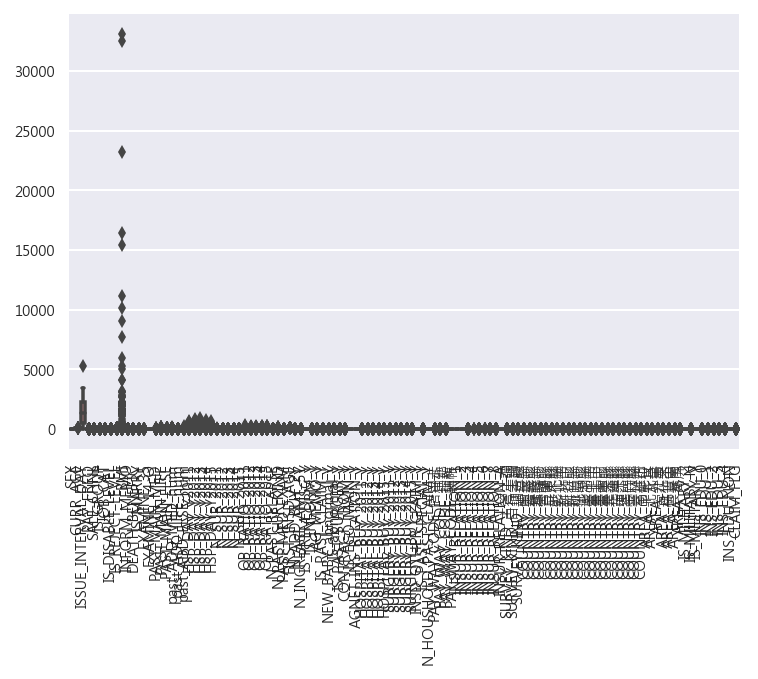

In [13]:
plot = sns.boxplot(data=TrainData_for_SCAL);
plot.set_xticklabels(plot.get_xticklabels(), rotation=90);

In [14]:
TrainX = TrainData_for_SCAL.drop([TargetY],axis = 1)
TrainY = TrainData_for_SCAL[TargetY]


0.0    1240716
1.0      24491
Name: CLAIM_FLG, dtype: int64


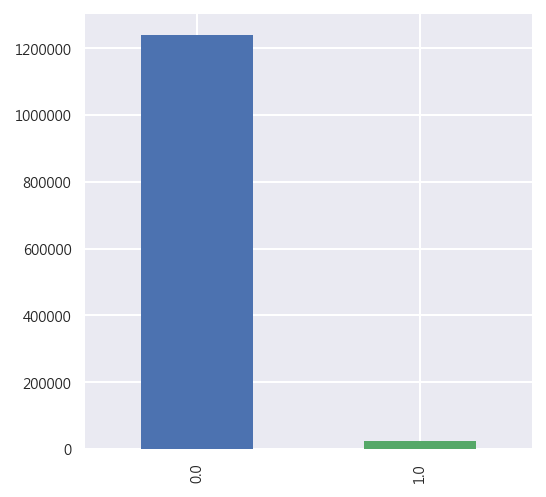

In [16]:
print(TrainY.value_counts())
TrainData_for_SCAL[TargetY].value_counts().plot(kind='bar', figsize=(4, 4))

In [15]:
#Scaler = MinMaxScaler(feature_range=(0, 1))
#Scaler = StandardScaler()
#Scaler = RobustScaler()
#Scaler = Normalizer()
Scaler = QuantileTransformer()

#reduced3 = FastICA(n_components=3)
#reduced3 = TSNE(n_components=3)
#reduced3 = FactorAnalysis(n_components=3)
reduced3 = PCA(n_components=3)
#reduced3 = NMF(n_components=3)
#reduced3 = TruncatedSVD(n_components=3)
#reduced3 = LinearDiscriminantAnalysis(n_components=3)

Reduce3_Scaler = make_pipeline(Scaler, reduced3)

[[-0.96469376 -0.11228412  1.17688131]]


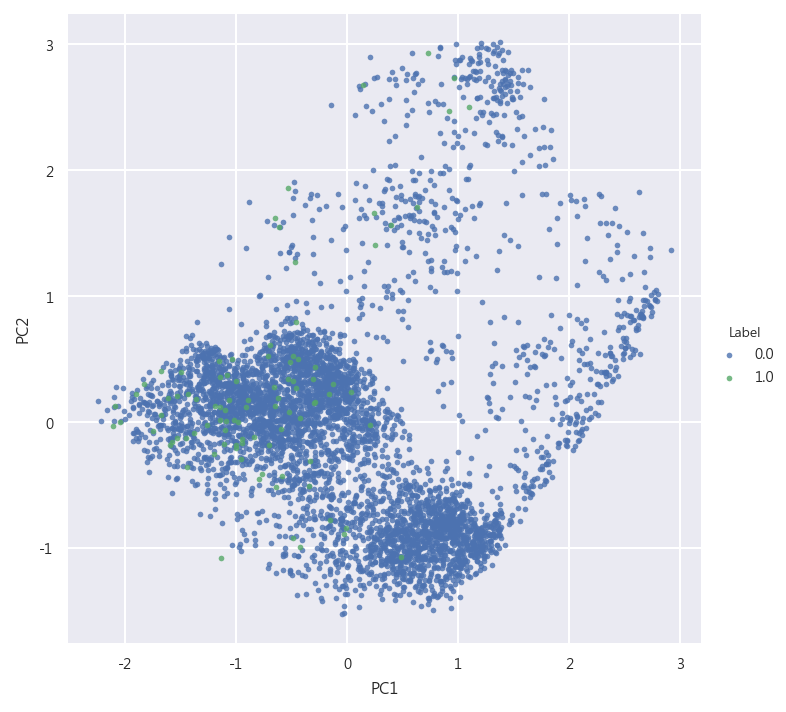

In [18]:
Draw_X = TrainX[:min(5000,TrainX.shape[0])]
Draw_Y = TrainY[:min(5000,TrainY.shape[0])]
DataX_Reduced = Reduce3_Scaler.fit_transform(Draw_X,Draw_Y)
print(DataX_Reduced[:1])

DataFrameX = pd.DataFrame(DataX_Reduced, columns = ['PC1', 'PC2', 'PC3'])
DataFrameX['Label'] = Draw_Y.values

sns.lmplot(x ='PC1', y ='PC2', data = DataFrameX, hue = 'Label',fit_reg = False, scatter_kws = {'s':8});
#plt.savefig('destfile.jpg', dpi = 300);

In [19]:
traces = []
for name in set(Draw_Y):
    trace = Scatter3d(
        x = DataX_Reduced[Draw_Y == name,0],
        y = DataX_Reduced[Draw_Y == name,1],
        z = DataX_Reduced[Draw_Y == name,2],
        mode = 'markers',
        name = name,
        marker = { 'size': 3},)
    traces.append(trace)
data = Data(traces)
layout = Layout(xaxis = XAxis(title = 'PC1', showline = False),
                yaxis = YAxis(title = 'PC2', showline = False),
                margin = dict(l = 0,r = 0,b = 0,t = 0))
fig = Figure(data = data,layout = layout)
py.iplot(fig,filename = 'TrainData-3d-scatter')

# 模型訓練

In [16]:
if TrainData_for_SCAL.isnull().sum().sum() > 0 or TestData_for_SCAL.isnull().sum().sum() >0 :
    print('請回到 填補缺失值 章節進行填值處理')
if list(TrainData_for_SCAL.select_dtypes(include = [object]).columns) != [] or list(TestData_for_SCAL.select_dtypes(include = [object]).columns) != [] :
    print('請回到 將非數值特徵轉為數值 章節進行非數值特徵處理')


In [17]:
TrainX = TrainData_for_SCAL.drop([TargetY],axis=1)
TrainY = TrainData_for_SCAL[TargetY]

TestX = TestData_for_SCAL if TargetY not in TestData_for_SCAL.columns else TestData_for_SCAL.drop([TargetY],axis = 1)
TestY = None if (TargetY not in TestData_for_SCAL.columns) or TestData_for_SCAL[TargetY].isnull().all().all() else TestData_for_SCAL[TargetY]

TrainX_Na = TrainData_Na.drop([TargetY],axis = 1)


TestX_Na = TestData_Na if TargetY not in TestData_Na.columns.values else TestData_Na.drop([TargetY],axis = 1)

In [18]:
#Scaler = QuantileTransformer()
Scaler = MinMaxScaler()
#Scaler = StandardScaler()
#Scaler = RobustScaler()
#Scaler = Normalizer()

TrainX_Scaler = Scaler.fit_transform(TrainX)
TestX_Scaler = Scaler.transform(TestX)

In [19]:
TrainX = pd.DataFrame(TrainX,columns = TrainData_for_SCAL.drop([TargetY],axis = 1).columns)
TrainX_Scaler = pd.DataFrame(TrainX_Scaler,columns = TrainData_for_SCAL.drop([TargetY],axis = 1).columns)
TestX = pd.DataFrame(TestX,columns = TestData_for_SCAL.drop([TargetY],axis = 1).columns)
TestX_Scaler = pd.DataFrame(TestX_Scaler,columns = TestData_for_SCAL.drop([TargetY],axis = 1).columns)
TrainY = pd.Series(TrainY) 
TestY = pd.Series(TestY) if TestY is not None else TestY

TrainX_Na = pd.DataFrame(TrainX_Na,columns = TrainData_Na.drop([TargetY],axis = 1).columns)


'同時建立表格儲存真實答案'
TrainPredict = pd.DataFrame()
TestPredict  = pd.DataFrame()
train_prob = pd.DataFrame() if not os.path.exists(Output_train_prob) else pd.read_csv(Output_train_prob)
test_prob  = pd.DataFrame() if not os.path.exists(Output_test_prob) else pd.read_csv(Output_test_prob)

train_prob['Truth'] = TrainY.values
if TestY is not None:
    test_prob['Truth'] = TestY.values 
    test_prob.to_csv(Output_test_prob, index=False,header=True,encoding = 'utf8')

train_prob.to_csv(Output_train_prob, index=False,header=True,encoding = 'utf8')


In [20]:
import pickle
from sklearn.base import clone
from sklearn.utils import shuffle
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, GridSearchCV, train_test_split

ordercols  = ['Algorithm','Accuracy','Precision','Recall','f1_score','ROC_AUC',"Cohen's kappa","JaccardSim","HammingLoss",'confusion_matrix']
TestReport = pd.DataFrame(columns=ordercols)
TrainReport = pd.DataFrame(columns=ordercols)
Train_Valid_Acc = {}
Train_Acc = {}
Test_Acc  = {}

from collections import OrderedDict
def Report_Metrics(TestReport,Method,y_true,y_pred,y_score) :
    temp = OrderedDict({'Algorithm' : Method,
            'Accuracy'  : accuracy_score(y_true,y_pred),
            'Precision' : precision_score(y_true,y_pred, average = 'weighted'),
            'Recall'    : recall_score(y_true,y_pred, average = 'weighted'),
            'f1_score'  : f1_score(y_true,y_pred, average = 'macro'),
            'confusion_matrix' : confusion_matrix(y_true,y_pred),
            "Cohen's kappa"    : cohen_kappa_score(y_true,y_pred),
            "HammingLoss" : -hamming_loss(y_true,y_pred),
            "JaccardSim"  : jaccard_similarity_score(y_true,y_pred),            
           })
    if NoClasses == 2:
        temp.update({'ROC_AUC' : roc_auc_score(y_true,y_score[:,1])})
    return pd.DataFrame([temp],columns = ordercols)

class OneFold:
    def split(self,dataX,dataY=None):
        yield dataX.index.values,dataX.index.values
    n_splits=1

folds = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = Random_State) if n_splits >1 else OneFold()

Prob_Train_shape = (TrainX.shape[0],NoClasses) # if NoClasses > 2 else (TrainY.shape[0],1)
Prob_Test_shape = (TestX.shape[0],NoClasses)# if NoClasses > 2 else (TestY.shape[0],1)

print('訓練資料筆數：', TrainX.shape[0], '   訓練資料欄位數：',TrainX.shape[1])
print('測試資料筆數：', TestX.shape[0] , '   測試資料欄位數：',TestX.shape[1])

訓練資料筆數： 1265207    訓練資料欄位數： 119
測試資料筆數： 316301    測試資料欄位數： 119


In [21]:
from sklearn.dummy import DummyClassifier

clf_probs = np.zeros(Prob_Train_shape)

clf = DummyClassifier(strategy = 'stratified',random_state = Random_State)

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(TrainX,TrainY)) :
    train_x, train_y, valid_x, valid_y = TrainX.iloc[train_idx], TrainY.iloc[train_idx] ,TrainX.iloc[valid_idx], TrainY.iloc[valid_idx]

    clf.fit(train_x, train_y)
    
    clf_probs[valid_idx] += clf.predict_proba(valid_x).copy() 
    
acc_dummy = roc_auc_score(TrainY,clf_probs[:,1]) if NoClasses == 2 else f1_score(TrainY,clf.classes_[np.argmax(clf_probs,axis=1)],average='macro')
    
print ('DummyClassifier 的交叉驗證 ROC AUC：'+str (acc_dummy) +'\n' if NoClasses == 2 
       else 'DummyClassifier 的交叉驗證準確率：'+str (acc_dummy) +'\n')

report = classification_report(TrainY, clf.classes_[np.argmax(clf_probs,axis=1)])
print('以下是 DummyClassifier 的分類與驗證，這是用來作為Baseline的分類器，不具備分類預測能力', os.linesep,report)


DummyClassifier 的交叉驗證 ROC AUC：0.49971858022407967

以下是 DummyClassifier 的分類與驗證，這是用來作為Baseline的分類器，不具備分類預測能力 
              precision    recall  f1-score   support

        0.0       0.98      0.98      0.98   1240716
        1.0       0.02      0.02      0.02     24491

avg / total       0.96      0.96      0.96   1265207



## 決策樹

In [27]:
from sklearn.tree import DecisionTreeClassifier
clfname='DecisionTree'

clf = DecisionTreeClassifier(random_state = Random_State,class_weight ='balanced')

(train_idx, valid_idx) = next(folds.split(TrainX, TrainY)) 
flag_idx = train_idx
train_x, train_y, valid_x, valid_y = TrainX.iloc[train_idx], TrainY.iloc[train_idx] ,TrainX.iloc[valid_idx], TrainY.iloc[valid_idx]

clf.fit(train_x, train_y)
    
valid_y_pred_prob = clf.predict_proba(valid_x).copy() 
    
acc = roc_auc_score(valid_y,valid_y_pred_prob[:,1]) if NoClasses == 2 else f1_score(valid_y,clf.classes_[np.argmax(valid_y_pred_prob,axis=1)],average='macro')
    
print (clfname+' 的初步驗證 ROC AUC：'+str(acc.round(8)) +'\n' if NoClasses == 2 
       else clfname+' 的初步驗證 f1準確率：'+str(acc.round(8)) +'\n')

report = classification_report(valid_y, clf.classes_[np.argmax(valid_y_pred_prob,axis=1)])
print('以下是 ',clfname,' 的初步驗證分類預測結果 : ', os.linesep,os.linesep,report)

print(clfname,' 初步驗證的準確度為', acc.round(8), '，大約是 Baseline DummyClassifier 的' , (acc / acc_dummy).round(3),'倍')

DecisionTree 的初步驗證 ROC AUC：0.59791443

以下是  DecisionTree  的初步驗證分類預測結果 :  
 
              precision    recall  f1-score   support

        0.0       0.98      0.98      0.98    413572
        1.0       0.20      0.21      0.21      8164

avg / total       0.97      0.97      0.97    421736

DecisionTree  初步驗證的準確度為 0.59791443 ，大約是 Baseline DummyClassifier 的 1.197 倍


In [28]:
clf_probs = np.zeros(Prob_Train_shape)
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(TrainX, TrainY)) :
    if (n_fold > 0) | (np.array_equiv(flag_idx ,train_idx)):
        train_x, train_y, valid_x, valid_y = TrainX.iloc[train_idx], TrainY.iloc[train_idx] ,TrainX.iloc[valid_idx], TrainY.iloc[valid_idx]
        clf = clone(clf)
        clf.fit(train_x, train_y)
    prob = clf.predict_proba(valid_x) if (n_fold > 0) | (np.array_equiv(flag_idx ,train_idx)) else valid_y_pred_prob
    
    with open(r"Model/"+clfname+str(n_fold+1)+".model", "wb") as output_file:
        pickle.dump(clf, output_file) 
    acc = roc_auc_score(valid_y,prob[:,1]) if NoClasses == 2 else f1_score(valid_y,clf.classes_[np.argmax(prob,axis=1)],average='macro')

    print (clfname+' '+str(n_fold+1)+'-fold 的 ROC AUC：'+str (acc.round(8)) +'\n' if NoClasses == 2 
           else clfname+' '+str(n_fold+1)+'-fold 的 f1準確率：'+str (acc.round(8)) +'\n')
        
    clf_probs[valid_idx] += prob 

clf_preds = clf.classes_[np.argmax(clf_probs,axis=1)]     
acc = roc_auc_score(TrainY,clf_probs[:,1]) if NoClasses == 2 else f1_score(TrainY,clf_preds,average='macro')
    
print ('完整交叉驗證 ROC AUC：'+str (acc.round(8)) +'\n' if NoClasses == 2 
       else '完整交叉驗證準確率：'+str (acc.round(8)) +'\n')

report = classification_report(TrainY, clf_preds,digits=4)
print('以下為訓練資料的交叉驗證分類預測結果 : ',os.linesep,os.linesep,report)
        
TrainPredict = pd.DataFrame() if not os.path.exists(Output_train_Pred) else pd.read_csv(Output_train_Pred) 
train_prob = pd.DataFrame() if not os.path.exists(Output_train_prob) else pd.read_csv(Output_train_prob)
    
TrainPredict[clfname] = clf.classes_[np.argmax(clf_probs,axis=1)]  
  
col_names = [clfname +'_'+ str(int(s))  for s in clf.classes_] 
Train_pro_temp = pd.DataFrame(clf_probs, columns=col_names)
for col in col_names:
    train_prob[col] = Train_pro_temp[col]

TrainReport = pd.concat([TrainReport,Report_Metrics(
TrainReport,clfname,TrainY,clf_preds,clf_probs)]).drop_duplicates(subset=['Algorithm'],keep='last')
    
train_prob.to_csv(Output_train_prob, index=False,header=True,encoding = 'utf8')
TrainPredict.to_csv(Output_train_Pred, index=False,header=True,encoding = 'utf8')


DecisionTree 1-fold 的 ROC AUC：0.59791443

DecisionTree 2-fold 的 ROC AUC：0.59921183

DecisionTree 3-fold 的 ROC AUC：0.59952079

完整交叉驗證 ROC AUC：0.59888232

以下為訓練資料的交叉驗證分類預測結果 :  
 
              precision    recall  f1-score   support

        0.0     0.9845    0.9834    0.9840   1240716
        1.0     0.2035    0.2143    0.2088     24491

avg / total     0.9694    0.9686    0.9690   1265207



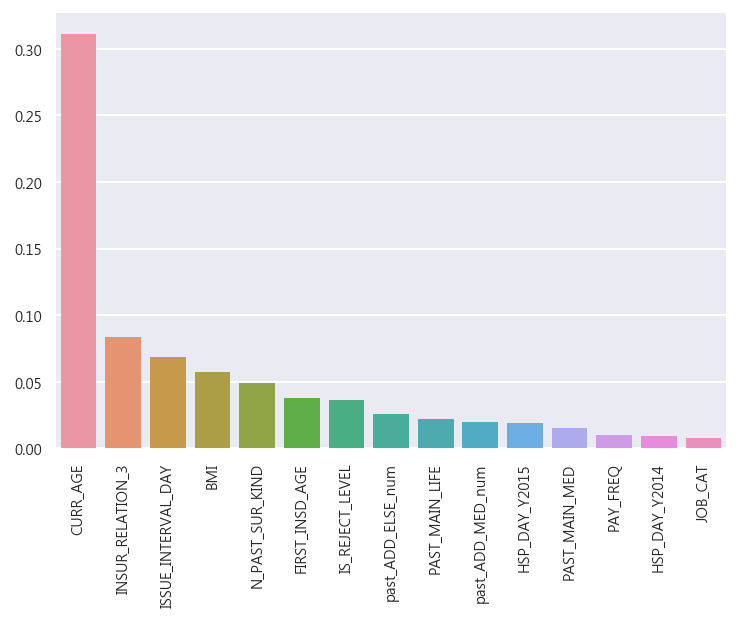

In [29]:
col_size = len(TrainX_Na.columns) if TrainX_Na.columns.size < 15 else 15
important_columns = [x for _,x in sorted(zip(clf.feature_importances_,TrainX_Na.columns),reverse = True)]
sns.set(font_scale = 0.7,font = "Microsoft JhengHei")
barplot = sns.barplot(x = important_columns[:col_size], y = sorted(clf.feature_importances_,reverse = True)[:col_size],order = important_columns[:col_size])
barplot.set_xticklabels(barplot.get_xticklabels(), rotation = 90);

In [30]:
clf_probs_test = np.zeros(Prob_Test_shape)

for i in range(n_splits):
    with open(r"Model/"+clfname+str(i+1)+".model", "rb") as input_file:
        clf = pickle.load(input_file)        
    clf_probs_test += clf.predict_proba(TestX)/n_splits
    
TestPredict = pd.DataFrame() if not os.path.exists(Output_test_Pred) else pd.read_csv(Output_test_Pred) 
test_prob = pd.DataFrame() if not os.path.exists(Output_test_prob) else pd.read_csv(Output_test_prob)
    
TestPredict[clfname] =clf.classes_[np.argmax(clf_probs_test,axis=1)]  

for i,col in enumerate( [clfname +'_'+ str(int(s))  for s in clf.classes_] ):
    test_prob[col] = clf_probs_test[:,i]

    
if TestY is not None:
    acc = roc_auc_score(TestY,clf_probs_test[:,1]) if NoClasses == 2 else f1_score(TestY,TestPredict[clfname],average='macro')
    
    print ('完整交叉驗證 ROC AUC：'+str (acc.round(8)) +'\n' if NoClasses == 2 
           else '完整交叉驗證準確率：'+str (acc.round(8)) +'\n')

    if 'Truth' not in test_prob.columns:
        test_prob.insert(0, 'Truth', TestY.values)
    if 'Truth' not in TestPredict:
        TestPredict.insert(0, 'Truth', TestY.values)
    report = classification_report(TestY, TestPredict[clfname],digits=4)
     
    print('以下為測試資料的分類預測結果 : ', os.linesep,os.linesep,report)  

    TestReport = pd.concat([TestReport,Report_Metrics(
    TestReport,clfname,test_prob['Truth'],TestPredict[clfname],clf_probs_test)]).drop_duplicates(subset=['Algorithm'],keep='last')

test_prob.to_csv(Output_test_prob, index=False,header=True,encoding = 'utf8')
TestPredict.to_csv(Output_test_Pred, index=False,header=True,encoding = 'utf8')
print('測試資料的分類預測機率與結果已存入檔案')

完整交叉驗證 ROC AUC：0.676237

以下為測試資料的分類預測結果 :  
 
              precision    recall  f1-score   support

        0.0     0.9841    0.9950    0.9895    310154
        1.0     0.4265    0.1877    0.2607      6147

avg / total     0.9732    0.9793    0.9753    316301

測試資料的分類預測機率與結果已存入檔案


## 隨機森林

In [27]:
from sklearn.ensemble import RandomForestClassifier
clfname='RandomForest'
clf = RandomForestClassifier(random_state=Random_State,n_jobs=n_jobs,n_estimators =100,class_weight ='balanced_subsample')

(train_idx, valid_idx) = next(folds.split(TrainX, TrainY)) 
flag_idx = train_idx
train_x, train_y, valid_x, valid_y = TrainX.iloc[train_idx], TrainY.iloc[train_idx] ,TrainX.iloc[valid_idx], TrainY.iloc[valid_idx]

clf.fit(train_x, train_y)
    
valid_y_pred_prob = clf.predict_proba(valid_x).copy() 
    
acc = roc_auc_score(valid_y,valid_y_pred_prob[:,1]) if NoClasses == 2 else f1_score(valid_y,clf.classes_[np.argmax(valid_y_pred_prob,axis=1)],average='macro')
    
print (clfname+' 的初步驗證 ROC AUC：'+str(acc.round(8)) +'\n' if NoClasses == 2 
       else clfname+' 的初步驗證 f1準確率：'+str(acc.round(8)) +'\n')

report = classification_report(valid_y, clf.classes_[np.argmax(valid_y_pred_prob,axis=1)])
print('以下是 ',clfname,' 的初步驗證分類預測結果 : ', os.linesep,os.linesep,report)

    
print(clfname,' 初步驗證的準確度為', acc.round(8), '，大約是 Baseline DummyClassifier 的' , (acc / acc_dummy).round(3),'倍')

RandomForest 的初步驗證 ROC AUC：0.87644922

以下是  RandomForest  的初步驗證分類預測結果 :  
 
              precision    recall  f1-score   support

        0.0       0.98      1.00      0.99    413572
        1.0       0.81      0.08      0.15      8164

avg / total       0.98      0.98      0.97    421736

RandomForest  初步驗證的準確度為 0.87644922 ，大約是 Baseline DummyClassifier 的 1.754 倍


In [28]:
clf_probs = np.zeros(Prob_Train_shape)
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(TrainX, TrainY)) :
    if (n_fold > 0) | (np.array_equiv(flag_idx ,train_idx)):
        train_x, train_y, valid_x, valid_y = TrainX.iloc[train_idx], TrainY.iloc[train_idx] ,TrainX.iloc[valid_idx], TrainY.iloc[valid_idx]
        clf = clone(clf)
        clf.fit(train_x, train_y)
    prob = clf.predict_proba(valid_x) if (n_fold > 0) | (np.array_equiv(flag_idx ,train_idx)) else valid_y_pred_prob
    
    with open(r"Model/"+clfname+str(n_fold+1)+".model", "wb") as output_file:
        pickle.dump(clf, output_file) 
    acc = roc_auc_score(valid_y,prob[:,1]) if NoClasses == 2 else f1_score(valid_y,clf.classes_[np.argmax(prob,axis=1)],average='macro')

    print (clfname+' '+str(n_fold+1)+'-fold 的 ROC AUC：'+str (acc.round(8)) +'\n' if NoClasses == 2 
           else clfname+' '+str(n_fold+1)+'-fold 的 f1準確率：'+str (acc.round(8)) +'\n')
        
    clf_probs[valid_idx] += prob 

clf_preds = clf.classes_[np.argmax(clf_probs,axis=1)]     
acc = roc_auc_score(TrainY,clf_probs[:,1]) if NoClasses == 2 else f1_score(TrainY,clf_preds,average='macro')
    
print ('完整交叉驗證 ROC AUC：'+str (acc.round(8)) +'\n' if NoClasses == 2 
       else '完整交叉驗證準確率：'+str (acc.round(8)) +'\n')

report = classification_report(TrainY, clf_preds,digits=4)
print('以下為訓練資料的交叉驗證分類預測結果 : ',os.linesep,os.linesep,report)
        
TrainPredict = pd.DataFrame() if not os.path.exists(Output_train_Pred) else pd.read_csv(Output_train_Pred) 
train_prob = pd.DataFrame() if not os.path.exists(Output_train_prob) else pd.read_csv(Output_train_prob)
    
TrainPredict[clfname] = clf.classes_[np.argmax(clf_probs,axis=1)]  
  
col_names = [clfname +'_'+ str(int(s))  for s in clf.classes_] 
Train_pro_temp = pd.DataFrame(clf_probs, columns=col_names)
for col in col_names:
    train_prob[col] = Train_pro_temp[col]

TrainReport = pd.concat([TrainReport,Report_Metrics(
TrainReport,clfname,TrainY,clf_preds,clf_probs)]).drop_duplicates(subset=['Algorithm'],keep='last')
    
train_prob.to_csv(Output_train_prob, index=False,header=True,encoding = 'utf8')
TrainPredict.to_csv(Output_train_Pred, index=False,header=True,encoding = 'utf8')


RandomForest 1-fold 的 ROC AUC：0.87644922

RandomForest 2-fold 的 ROC AUC：0.87721986

RandomForest 3-fold 的 ROC AUC：0.87712737

完整交叉驗證 ROC AUC：0.8769325

以下為訓練資料的交叉驗證分類預測結果 :  
 
              precision    recall  f1-score   support

        0.0     0.9822    0.9996    0.9908   1240716
        1.0     0.8074    0.0806    0.1466     24491

avg / total     0.9788    0.9818    0.9745   1265207



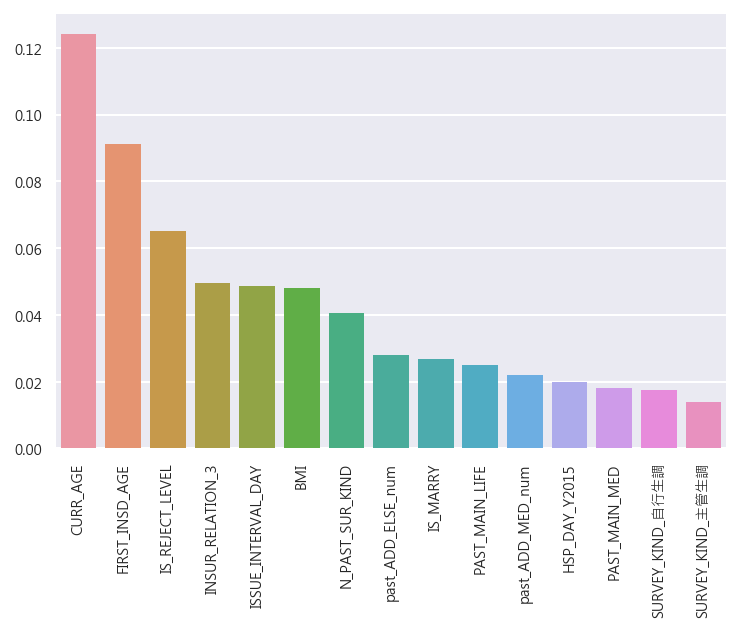

In [29]:
col_size = len(TrainX_Na.columns) if TrainX_Na.columns.size < 15 else 15
important_columns = [x for _,x in sorted(zip(clf.feature_importances_,TrainX_Na.columns),reverse = True)]
sns.set(font_scale = 0.7,font = "Microsoft JhengHei")
barplot = sns.barplot(x = important_columns[:col_size], y = sorted(clf.feature_importances_,reverse = True)[:col_size],order = important_columns[:col_size])
barplot.set_xticklabels(barplot.get_xticklabels(), rotation = 90);

In [30]:
clf_probs_test = np.zeros(Prob_Test_shape)

for i in range(n_splits):
    with open(r"Model/"+clfname+str(i+1)+".model", "rb") as input_file:
        clf = pickle.load(input_file)        
    clf_probs_test += clf.predict_proba(TestX)/n_splits
    
TestPredict = pd.DataFrame() if not os.path.exists(Output_test_Pred) else pd.read_csv(Output_test_Pred) 
test_prob = pd.DataFrame() if not os.path.exists(Output_test_prob) else pd.read_csv(Output_test_prob)
    
TestPredict[clfname] =clf.classes_[np.argmax(clf_probs_test,axis=1)]  

for i,col in enumerate( [clfname +'_'+ str(int(s))  for s in clf.classes_] ):
    test_prob[col] = clf_probs_test[:,i]

    
if TestY is not None:
    acc = roc_auc_score(TestY,clf_probs_test[:,1]) if NoClasses == 2 else f1_score(TestY,TestPredict[clfname],average='macro')
    
    print ('完整交叉驗證 ROC AUC：'+str (acc.round(8)) +'\n' if NoClasses == 2 
           else '完整交叉驗證準確率：'+str (acc.round(8)) +'\n')

    if 'Truth' not in test_prob.columns:
        test_prob.insert(0, 'Truth', TestY.values)
    if 'Truth' not in TestPredict:
        TestPredict.insert(0, 'Truth', TestY.values)
    report = classification_report(TestY, TestPredict[clfname],digits=4)
     
    print('以下為測試資料的分類預測結果 : ', os.linesep,os.linesep,report)  

    TestReport = pd.concat([TestReport,Report_Metrics(
    TestReport,clfname,test_prob['Truth'],TestPredict[clfname],clf_probs_test)]).drop_duplicates(subset=['Algorithm'],keep='last')

test_prob.to_csv(Output_test_prob, index=False,header=True,encoding = 'utf8')
TestPredict.to_csv(Output_test_Pred, index=False,header=True,encoding = 'utf8')
print('測試資料的分類預測機率與結果已存入檔案')

完整交叉驗證 ROC AUC：0.89620406

以下為測試資料的分類預測結果 :  
 
              precision    recall  f1-score   support

        0.0     0.9820    0.9996    0.9908    310154
        1.0     0.8057    0.0776    0.1416      6147

avg / total     0.9786    0.9817    0.9743    316301

測試資料的分類預測機率與結果已存入檔案


## ExtraTree 

## XGBOOST

In [23]:
import xgboost as xgb
temp = TrainData[TargetY].value_counts().sort_values(ascending = False).tolist() if NoClasses == 2 else None 
clf = xgb.XGBClassifier(nthread = n_jobs,n_estimators=1000, learning_rate=0.2, tree_method ='hist',grow_policy ='lossguide',scale_pos_weight = temp[0]/temp[1] if NoClasses == 2 else 1)
#param = {'max_depth':5, 'objective':'multi:softmax', 'subsample':0.8, 'n_estimators':1000,'colsample_bytree':0.8, 'eta':0.1, 'nthread' : n_jobs,'tree_method':'gpu_hist',} #
#clf = xgb.XGBClassifier(**param)
del temp
clfname='XGBoost'

(train_idx, valid_idx) = next(folds.split(TrainX, TrainY)) 
flag_idx = train_idx
train_x, train_y, valid_x, valid_y = TrainX_Na.iloc[train_idx], TrainY.iloc[train_idx] ,TrainX_Na.iloc[valid_idx], TrainY.iloc[valid_idx]

clf.fit(train_x, train_y,  eval_metric='auc' if NoClasses == 2 else 'mlogloss'
        ,eval_set = [(train_x, train_y), (valid_x, valid_y)], verbose = 100,early_stopping_rounds = 100)
    
valid_y_pred_prob = clf.predict_proba(valid_x,ntree_limit=clf.best_iteration).copy() 
    
acc = roc_auc_score(valid_y,valid_y_pred_prob[:,1]) if NoClasses == 2 else f1_score(valid_y,clf.classes_[np.argmax(valid_y_pred_prob,axis=1)],average='macro')
print( os.linesep)    
print (clfname+' 的初步驗證 ROC AUC：'+str(acc.round(8)) +'\n' if NoClasses == 2 
       else clfname+' 的初步驗證 f1準確率：'+str(acc.round(8)) +'\n')

report = classification_report(valid_y, clf.classes_[np.argmax(valid_y_pred_prob,axis=1)])
print('以下是 ',clfname,' 的初步驗證分類預測結果 : ', os.linesep,os.linesep,report)

print(clfname,' 初步驗證的準確度為', acc.round(8), '，大約是 Baseline DummyClassifier 的' , (acc / acc_dummy).round(3),'倍')




[05:15:56] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[0]	validation_0-auc:0.863527	validation_1-auc:0.862515
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.911638	validation_1-auc:0.90684
[200]	validation_0-auc:0.916538	validation_1-auc:0.908073
[300]	validation_0-auc:0.920232	validation_1-auc:0.907644
Stopping. Best iteration:
[209]	validation_0-auc:0.916906	validation_1-auc:0.908089



XGBoost 的初步驗證 ROC AUC：0.90805622

以下是  XGBoost  的初步驗證分類預測結果 :  
 
              precision    recall  f1-score   support

        0.0       1.00      0.84      0.91    413572
        1.0       0.09      0.80      0.16      8164

avg / total       0.98      0.83      0.89    421736

XGBoost  初步驗證的準確度為 0.90805622 ，大約是 Baseline DummyClassifier 的 1.817 倍


In [24]:

clf_probs = np.zeros(Prob_Train_shape)

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(TrainX, TrainY)) :
    if (n_fold > 0) | (np.array_equiv(flag_idx ,train_idx)):
        train_x, train_y, valid_x, valid_y = TrainX_Na.iloc[train_idx], TrainY.iloc[train_idx] ,TrainX_Na.iloc[valid_idx], TrainY.iloc[valid_idx]
        clf = clone(clf)
        clf.fit(train_x, train_y,eval_set = [(train_x, train_y), (valid_x, valid_y)],eval_metric='auc' if NoClasses == 2 else 'mlogloss', verbose = 100,early_stopping_rounds = 100)
    prob = clf.predict_proba(valid_x, ntree_limit=clf.best_iteration) if (n_fold > 0) | (np.array_equiv(flag_idx ,train_idx)) else valid_y_pred_prob
    
    with open(r"Model/"+clfname+str(n_fold+1)+".model", "wb") as output_file:
        pickle.dump(clf, output_file) 
    acc = roc_auc_score(valid_y,prob[:,1]) if NoClasses == 2 else f1_score(valid_y,clf.classes_[np.argmax(prob,axis=1)],average='macro')

    print (clfname+' '+str(n_fold+1)+'-fold 的 ROC AUC：'+str (acc.round(8)) +'\n' if NoClasses == 2 
           else clfname+' '+str(n_fold+1)+'-fold 的 f1準確率：'+str (acc.round(8)) +'\n')
        
    clf_probs[valid_idx] += prob 

clf_preds = clf.classes_[np.argmax(clf_probs,axis=1)]     
acc = roc_auc_score(TrainY,clf_probs[:,1]) if NoClasses == 2 else f1_score(TrainY,clf_preds,average='macro')
    
print ('完整交叉驗證 ROC AUC：'+str (acc.round(8)) +'\n' if NoClasses == 2 
       else '完整交叉驗證準確率：'+str (acc.round(8)) +'\n')

report = classification_report(TrainY, clf_preds,digits=4)
print('以下為訓練資料的交叉驗證分類預測結果 : ',os.linesep,os.linesep,report)
        
TrainPredict = pd.DataFrame() if not os.path.exists(Output_train_Pred) else pd.read_csv(Output_train_Pred) 
train_prob = pd.DataFrame() if not os.path.exists(Output_train_prob) else pd.read_csv(Output_train_prob)
    
TrainPredict[clfname] = clf.classes_[np.argmax(clf_probs,axis=1)]  
  
col_names = [clfname +'_'+ str(int(s))  for s in clf.classes_] 
Train_pro_temp = pd.DataFrame(clf_probs, columns=col_names)
for col in col_names:
    train_prob[col] = Train_pro_temp[col]

TrainReport = pd.concat([TrainReport,Report_Metrics(
TrainReport,clfname,TrainY,clf_preds,clf_probs)]).drop_duplicates(subset=['Algorithm'],keep='last')
    
train_prob.to_csv(Output_train_prob, index=False,header=True,encoding = 'utf8')
TrainPredict.to_csv(Output_train_Pred, index=False,header=True,encoding = 'utf8')

[05:17:42] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[0]	validation_0-auc:0.863527	validation_1-auc:0.862515
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.911638	validation_1-auc:0.90684
[200]	validation_0-auc:0.916538	validation_1-auc:0.908073
[300]	validation_0-auc:0.920232	validation_1-auc:0.907644
Stopping. Best iteration:
[209]	validation_0-auc:0.916906	validation_1-auc:0.908089

XGBoost 1-fold 的 ROC AUC：0.90805622

[05:18:55] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.
[0]	validation_0-auc:0.863469	validation_1-auc:0.864303
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.911461	validation_1-auc:0.907888
[200]	validation_0-auc:

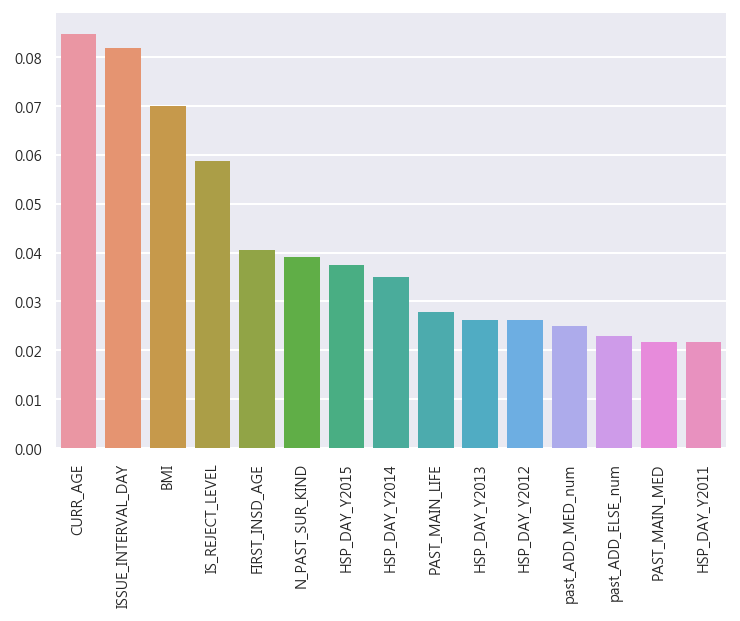

In [25]:
col_size = len(TrainX_Na.columns) if TrainX_Na.columns.size < 15 else 15
important_columns = [x for _,x in sorted(zip(clf.feature_importances_,TrainX_Na.columns),reverse = True)]
sns.set(font_scale = 0.7,font = "Microsoft JhengHei")
barplot = sns.barplot(x = important_columns[:col_size], y = sorted(clf.feature_importances_,reverse = True)[:col_size],order = important_columns[:col_size])
barplot.set_xticklabels(barplot.get_xticklabels(), rotation = 90);

In [26]:
clf_probs_test = np.zeros(Prob_Test_shape)

for i in range(n_splits):
    with open(r"Model/"+clfname+str(i+1)+".model", "rb") as input_file:
        clf = pickle.load(input_file)        
    clf_probs_test += clf.predict_proba(TestX_Na,ntree_limit=clf.best_iteration)/n_splits
    
TestPredict = pd.DataFrame() if not os.path.exists(Output_test_Pred) else pd.read_csv(Output_test_Pred) 
test_prob = pd.DataFrame() if not os.path.exists(Output_test_prob) else pd.read_csv(Output_test_prob)
    
TestPredict[clfname] =clf.classes_[np.argmax(clf_probs_test,axis=1)]  

for i,col in enumerate( [clfname +'_'+ str(int(s))  for s in clf.classes_] ):
    test_prob[col] = clf_probs_test[:,i]

    
if TestY is not None:
    acc = roc_auc_score(TestY,clf_probs_test[:,1]) if NoClasses == 2 else f1_score(TestY,TestPredict[clfname],average='macro')
    
    print ('完整交叉驗證 ROC AUC：'+str (acc.round(8)) +'\n' if NoClasses == 2 
           else '完整交叉驗證準確率：'+str (acc.round(8)) +'\n')

    if 'Truth' not in test_prob.columns:
        test_prob.insert(0, 'Truth', TestY.values)
    if 'Truth' not in TestPredict:
        TestPredict.insert(0, 'Truth', TestY.values)
    report = classification_report(TestY, TestPredict[clfname],digits=4)
     
    print('以下為測試資料的分類預測結果 : ', os.linesep,os.linesep,report)  

    TestReport = pd.concat([TestReport,Report_Metrics(
    TestReport,clfname,test_prob['Truth'],TestPredict[clfname],clf_probs_test)]).drop_duplicates(subset=['Algorithm'],keep='last')

test_prob.to_csv(Output_test_prob, index=False,header=True,encoding = 'utf8')
TestPredict.to_csv(Output_test_Pred, index=False,header=True,encoding = 'utf8')
print('測試資料的分類預測機率與結果已存入檔案')

完整交叉驗證 ROC AUC：0.91041872

以下為測試資料的分類預測結果 :  
 
              precision    recall  f1-score   support

        0.0     0.9955    0.8361    0.9088    310154
        1.0     0.0891    0.8087    0.1605      6147

avg / total     0.9779    0.8355    0.8943    316301

測試資料的分類預測機率與結果已存入檔案
